# Assignment 01: Python notebook for analysis

This notebook analyzes the netflix dataset and is used to answer various research and visualiztion questions. 




### Imports and data loading 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

SEED = 0
rng = np.random.default_rng(SEED)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

DATA_DIR = Path("../data/netflix")
CSV_PATH = DATA_DIR / "netflix_titles.csv"

In [2]:
df = pd.read_csv(CSV_PATH)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### Basic Data Cleaning 

1) checking for unknown values in the data 

In [3]:
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [4]:
# Fill missing country values
df["country"] = df["country"].fillna("Unknown")

# Remove rows missing date_added because we need the year
df = df.dropna(subset=["date_added"])

In [5]:
# Parse dates (coerce errors -> NaT)
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year

df[["title", "type", "date_added", "year_added"]].head(10)

,title,type,date_added,year_added
0,Dick Johnson Is Dead,Movie,2021-09-25,2021.0
1,Blood & Water,TV Show,2021-09-24,2021.0
2,Ganglands,TV Show,2021-09-24,2021.0
3,Jailbirds New Orleans,TV Show,2021-09-24,2021.0
4,Kota Factory,TV Show,2021-09-24,2021.0
5,Midnight Mass,TV Show,2021-09-24,2021.0
6,My Little Pony: A New Generation,Movie,2021-09-24,2021.0
7,Sankofa,Movie,2021-09-24,2021.0
8,The Great British Baking Show,TV Show,2021-09-24,2021.0
9,The Starling,Movie,2021-09-24,2021.0


2) Checking for duplicates in the data 

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df = df.drop_duplicates()

## Research Questions

##### Question 1)  How has the number of titles added to Netflix changed over time (by year)?

In [8]:
added_per_year = df.dropna(subset=["year_added"]).groupby("year_added").size()
added_per_year.tail()

year_added
2017.0    1164
2018.0    1625
2019.0    1999
2020.0    1878
2021.0    1498
dtype: int64

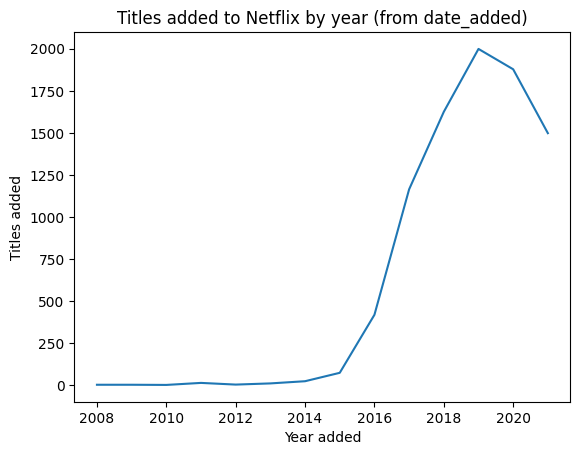

In [9]:
plt.figure()
plt.plot(added_per_year.index, added_per_year.values)
plt.xlabel("Year added")
plt.ylabel("Titles added")
plt.title("Titles added to Netflix by year (from date_added)")
plt.show()


This line graph shows the number of titles added to netflix each year. According to our data we can see a significant spike in the number of titles added between 2018 and 2020 

##### Question 2) Which countries (or genres/listed in categories) contribute the most titles, and how has that changed over time?

In [10]:
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year

df[["title", "date_added", "year_added", "country"]]


,title,date_added,year_added,country
0,Dick Johnson Is Dead,2021-09-25,2021.0,United States
1,Blood & Water,2021-09-24,2021.0,South Africa
2,Ganglands,2021-09-24,2021.0,Unknown
3,Jailbirds New Orleans,2021-09-24,2021.0,Unknown
4,Kota Factory,2021-09-24,2021.0,India
...,...,...,...,...
8802,Zodiac,2019-11-20,2019.0,United States
8803,Zombie Dumb,2019-07-01,2019.0,Unknown
8804,Zombieland,2019-11-01,2019.0,United States
8805,Zoom,2020-01-11,2020.0,United States


In [11]:
# country field can contain multiple countries separated by commas.
countries = (
    df["country"]
    .dropna()
    .str.split(",")
    .explode()
    .str.strip()
)
top_countries = countries.value_counts().head(10)
top_countries

country
United States     3684
India             1046
Unknown            830
United Kingdom     805
Canada             445
France             393
Japan              317
Spain              232
South Korea        231
Germany            226
Name: count, dtype: int64

In [12]:
country_year = (
    df.dropna(subset=["year_added", "country"])
      .assign(country=df["country"].str.split(","))
      .explode("country")
)

country_year["country"] = country_year["country"].str.strip()

country_year_counts = (
    country_year.groupby(["year_added", "country"])
                .size()
                .reset_index(name="count")
)

country_year_counts.head(10)



,year_added,country,count
0,2008.0,United States,2
1,2009.0,Denmark,1
2,2009.0,United States,1
3,2010.0,United States,1
4,2011.0,France,2
5,2011.0,Mexico,1
6,2011.0,Spain,1
7,2011.0,United Kingdom,1
8,2011.0,United States,12
9,2012.0,Mexico,1


In [13]:
top10 = top_countries.index.tolist()

country_year_top10 = country_year_counts[country_year_counts["country"].isin(top10)]
country_year_top10.head(10)


,year_added,country,count
0,2008.0,United States,2
2,2009.0,United States,1
3,2010.0,United States,1
4,2011.0,France,2
6,2011.0,Spain,1
7,2011.0,United Kingdom,1
8,2011.0,United States,12
10,2012.0,United States,3
11,2013.0,Canada,1
13,2013.0,United Kingdom,1


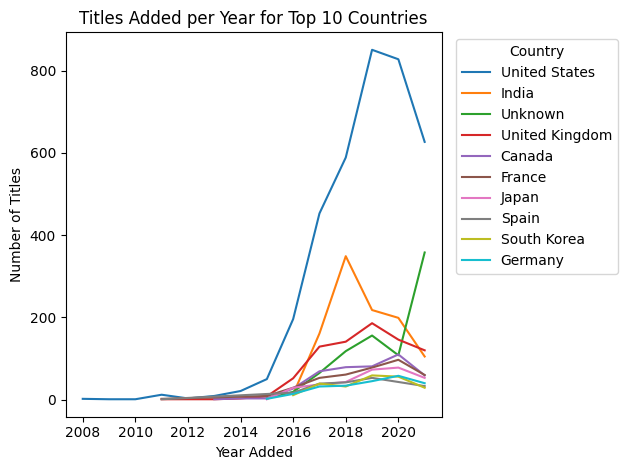

In [14]:
plt.figure()

for c in top10:
    subset = country_year_top10[country_year_top10["country"] == c].sort_values("year_added")
    plt.plot(subset["year_added"], subset["count"], label=c)

plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.title("Titles Added per Year for Top 10 Countries")
plt.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


This line chart shows the relationship of the number of releases per country based on the year. We are able to see that the United states has been able to maintain a lead but India overtook the United Kingdom to become second. 

## Analysis 1 - Trend Over Time: Titles Added Per Year

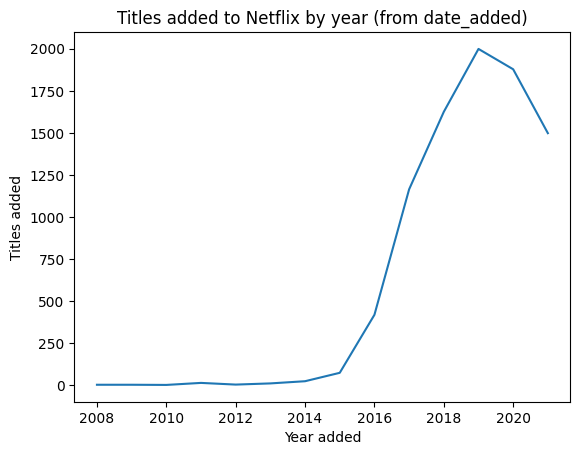

In [15]:
plt.figure()
plt.plot(added_per_year.index, added_per_year.values)
plt.xlabel("Year added")
plt.ylabel("Titles added")
plt.title("Titles added to Netflix by year (from date_added)")
plt.show()

Same line graph we saw earlier. This visual shows the number of titles per year. 

## Analysis 2 - Comparison of Two Groups with Metric: Movies vs TV Shows vs Release Year


In [16]:
df[["title", "type", "release_year"]].head(10)


,title,type,release_year
0,Dick Johnson Is Dead,Movie,2020
1,Blood & Water,TV Show,2021
2,Ganglands,TV Show,2021
3,Jailbirds New Orleans,TV Show,2021
4,Kota Factory,TV Show,2021
5,Midnight Mass,TV Show,2021
6,My Little Pony: A New Generation,Movie,2021
7,Sankofa,Movie,1993
8,The Great British Baking Show,TV Show,2021
9,The Starling,Movie,2021


In [17]:
avg_release = (
    df.groupby("type")["release_year"]
      .mean()
      .reset_index(name="average_release_year")
)

avg_release


,type,average_release_year
0,Movie,2013.121514
1,TV Show,2016.625656


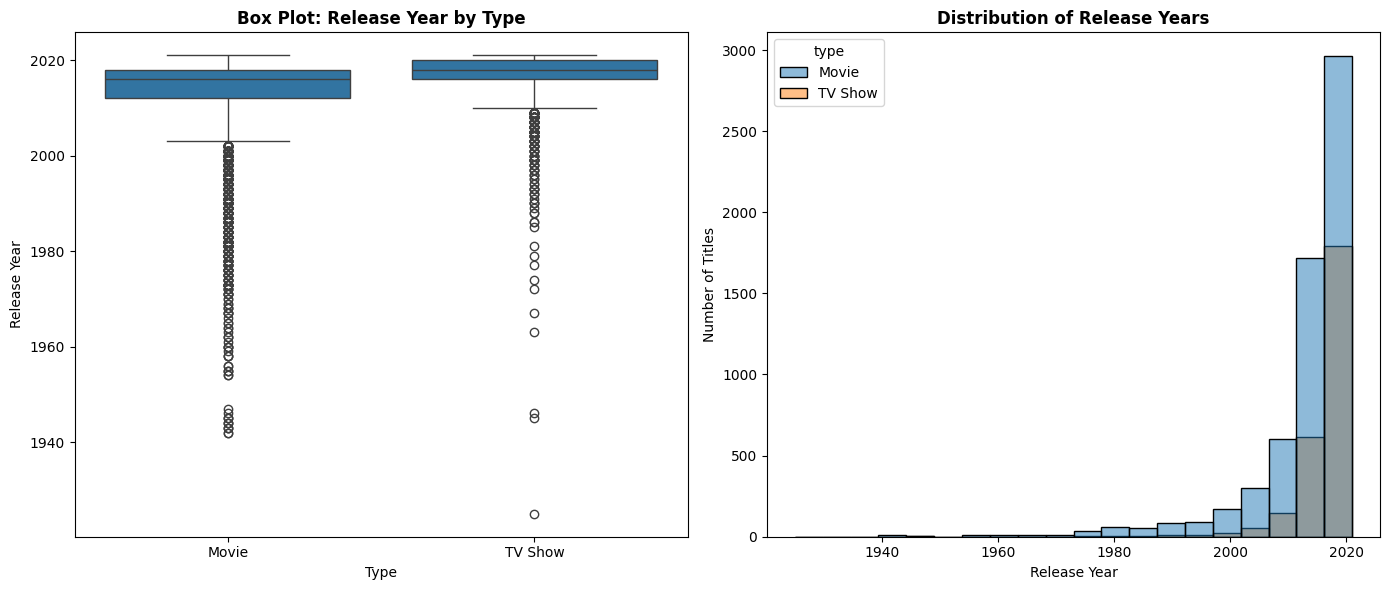

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=df, x="type", y="release_year", ax=axes[0])
axes[0].set_title("Box Plot: Release Year by Type", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Type")
axes[0].set_ylabel("Release Year")

sns.histplot(data=df, x="release_year", hue="type", bins=20, ax=axes[1])
axes[1].set_title("Distribution of Release Years", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Release Year")
axes[1].set_ylabel("Number of Titles")

plt.tight_layout()
plt.show()


These graphs show the relationship of Movies and TV shows by year. The histogram is better for seeing the distribution. 

## Relationship Graph - Movies vs TV

In [19]:
type_counts = df["type"].value_counts()
type_counts
    

type
Movie      6131
TV Show    2666
Name: count, dtype: int64

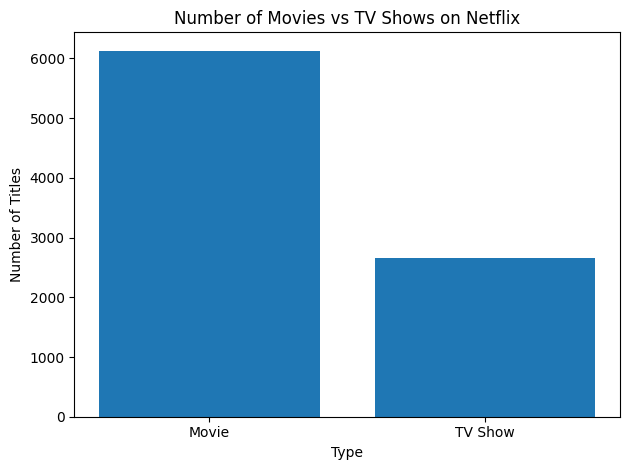

In [20]:
plt.figure()
plt.bar(type_counts.index, type_counts.values)
plt.xlabel("Type")
plt.ylabel("Number of Titles")
plt.title("Number of Movies vs TV Shows on Netflix")
plt.tight_layout()
plt.show()


Shows the number of titles added based on the category. We can see the movies make up more of the titles added to Netflix